# IMPORTING LIBRARIES AND DATA

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

In [4]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Replace 'file_id' with the actual file ID of your CSV file
file_id = '1-2qx1Shn2NLcjsTtcjnbba-v4qNGHuZk'
file_id2 = '1-EzON_NnR20m_L8wZUIIv0gKvHtZsLfh'
file_id3 = '1-IK0JLZWRWsV1TKW-9lG1ZTr-4dPhcM-'
file_id4 = '1-MBotSxQRfHSmB2rK8naP0-KQZIUjCPw'

# Create a file instance using the file ID
file = drive.CreateFile({'id': file_id})
file.GetContentFile('train_data_dictionary.csv')
file = drive.CreateFile({'id': file_id2})
file.GetContentFile('train_data.csv')
file = drive.CreateFile({'id': file_id3})
file.GetContentFile('test_data.csv')
file = drive.CreateFile({'id': file_id4})
file.GetContentFile('sample_submission.csv')

# Read the CSV file using pandas
df_des = pd.read_csv('train_data_dictionary.csv')
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')
df_submission = pd.read_csv('sample_sub.csv')

# Display the DataFrame
df_des

Column   
0                             case_id  \
1                       Hospital_code   
2                  Hospital_type_code   
3                  City_Code_Hospital   
4                Hospital_region_code   
5   Available Extra Rooms in Hospital   
6                          Department   
7                           Ward_Type   
8                  Ward_Facility_Code   
9                           Bed Grade   
10                          patientid   
11                  City_Code_Patient   
12                  Type of Admission   
13                Severity of Illness   
14              Visitors with Patient   
15                                Age   
16                  Admission_Deposit   
17                               Stay   

                                          Description  
0                      Case_ID registered in Hospital  
1                        Unique code for the Hospital  
2                Unique code for the type of Hospital  
3                           City Code of the Hospital  
4                         Region Code of the Hospital  
5     Number of Extra rooms available in the Hospital  
6                     Department overlooking the case  
7                              Code for the Ward type  
8                          Code for the Ward Facility  
9                        Condition of Bed in the Ward  
10                                  Unique Patient Id  
11                          City Code for the patient  
12          Admission Type registered by the Hospital  
13  Severity of the illness recorded at the time o...  
14                Number of Visitors with the patient  
15                                 Age of the patient  
16                      Deposit at the Admission Time  
17                           Stay Days by the patient

# EDA

In [6]:

df_train.head()

case_id  Hospital_code Hospital_type_code  City_Code_Hospital   
0        1              8                  c                   3  \
1        2              2                  c                   5   
2        3             10                  e                   1   
3        4             26                  b                   2   
4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department   
0                    Z                                  3  radiotherapy  \
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient   
0         R                  F        2.0      31397                7.0  \
1         S                  F        2.0      31397                7.0   
2         S                  E        2.0      31397                7.0   
3         R                  D        2.0      31397                7.0   
4         S                  D        2.0      31397                7.0   

  Type of Admission Severity of Illness  Visitors with Patient    Age   
0         Emergency             Extreme                      2  51-60  \
1            Trauma             Extreme                      2  51-60   
2            Trauma             Extreme                      2  51-60   
3            Trauma             Extreme                      2  51-60   
4            Trauma             Extreme                      2  51-60   

   Admission_Deposit   Stay  
0             4911.0   0-10  
1             5954.0  41-50  
2             4745.0  31-40  
3             7272.0  41-50  
4             5558.0  41-50

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [8]:
df_train.describe()

case_id  Hospital_code  City_Code_Hospital   
count  318438.000000  318438.000000       318438.000000  \
mean   159219.500000      18.318841            4.771717   
std     91925.276847       8.633755            3.102535   
min         1.000000       1.000000            1.000000   
25%     79610.250000      11.000000            2.000000   
50%    159219.500000      19.000000            5.000000   
75%    238828.750000      26.000000            7.000000   
max    318438.000000      32.000000           13.000000   

       Available Extra Rooms in Hospital      Bed Grade      patientid   
count                      318438.000000  318325.000000  318438.000000  \
mean                            3.197627       2.625807   65747.579472   
std                             1.168171       0.873146   37979.936440   
min                             0.000000       1.000000       1.000000   
25%                             2.000000       2.000000   32847.000000   
50%                             3.000000       3.000000   65724.500000   
75%                             4.000000       3.000000   98470.000000   
max                            24.000000       4.000000  131624.000000   

       City_Code_Patient  Visitors with Patient  Admission_Deposit  
count      313906.000000          318438.000000      318438.000000  
mean            7.251859               3.284099        4880.749392  
std             4.745266               1.764061        1086.776254  
min             1.000000               0.000000        1800.000000  
25%             4.000000               2.000000        4186.000000  
50%             8.000000               3.000000        4741.000000  
75%             8.000000               4.000000        5409.000000  
max            38.000000              32.000000       11008.000000

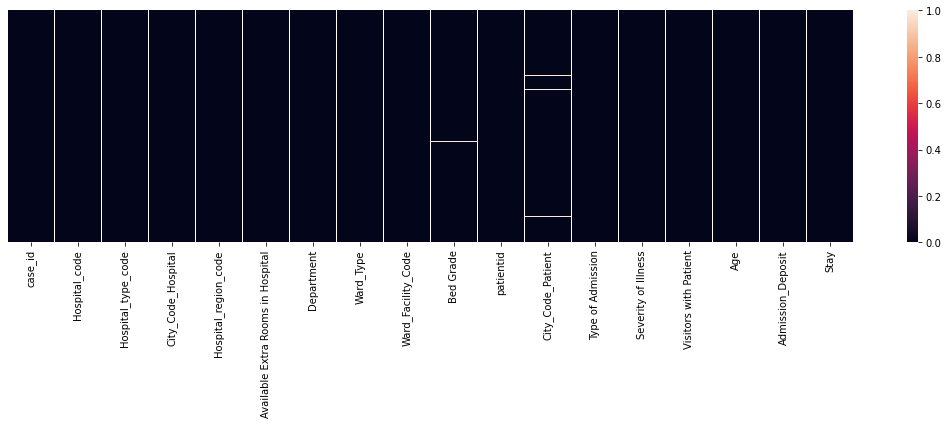

In [6]:
plt.figure(figsize=(15,6))
sns.heatmap(df_train.isna(),yticklabels=False)
plt.tight_layout()

In [7]:
df_train.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [8]:
df_train=df_train.dropna()

In [9]:
df_train=df_train.drop_duplicates()

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313793 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            313793 non-null  int64  
 1   Hospital_code                      313793 non-null  int64  
 2   Hospital_type_code                 313793 non-null  object 
 3   City_Code_Hospital                 313793 non-null  int64  
 4   Hospital_region_code               313793 non-null  object 
 5   Available Extra Rooms in Hospital  313793 non-null  int64  
 6   Department                         313793 non-null  object 
 7   Ward_Type                          313793 non-null  object 
 8   Ward_Facility_Code                 313793 non-null  object 
 9   Bed Grade                          313793 non-null  float64
 10  patientid                          313793 non-null  int64  
 11  City_Code_Patient                  313793 no

In [11]:
df_train.groupby(["Hospital_region_code", "City_Code_Hospital"]).Hospital_region_code.count()

Hospital_region_code  City_Code_Hospital
X                     1                     54181
                      4                     13577
                      6                     46128
                      11                    16947
Y                     2                     51178
                      7                     35144
                      9                     25947
                      10                     5188
                      13                     3592
Z                     3                     31168
                      5                     30743
Name: Hospital_region_code, dtype: int64

In [12]:
df_train.groupby(["Hospital_type_code", "Hospital_code", ]).Hospital_code.count()

Hospital_type_code  Hospital_code
a                   4                 1216
                    5                 5143
                    6                20016
                    7                 1269
                    12               11149
                    13                5178
                    14               16917
                    19               21035
                    23               26112
                    24                7835
                    27               14109
                    29               11092
b                   11               17107
                    20                1390
                    26               32681
                    28               16947
c                   2                 5050
                    3                 7030
                    8                 3611
                    15                9134
                    16                3631
                    21                8047
                    

In [13]:
df_train.groupby(["Department", "Hospital_type_code"]).Department.count()

Department          Hospital_type_code
TB & Chest disease  a                       3729
                    b                       2678
                    c                       1272
                    d                        562
                    e                        662
                    f                        398
                    g                        159
anesthesia          a                      14151
                    b                       6969
                    c                       3773
                    d                       1219
                    e                       2037
                    f                        735
                    g                        303
gynecology          a                     109360
                    b                      51758
                    c                      36459
                    d                      16692
                    e                      19657
                    f         

In [14]:
df_train.groupby(["Hospital_type_code", "Ward_Type"]).Hospital_code.count()

Hospital_type_code  Ward_Type
a                   P             2032
                    Q            50220
                    R            64191
                    S            23923
                    T              705
b                   P             1547
                    Q            26233
                    R            30050
                    S            10295
c                   P             1370
                    Q            14080
                    R            14436
                    S            15457
                    U                9
d                   Q             6903
                    R             6985
                    S             5513
                    T              760
e                   Q             7059
                    R             8406
                    S             8821
f                   S            10561
g                   R             2036
                    S             2201
Name: Hospital_code, dtype: int64

In [15]:
df_train.groupby(["Ward_Facility_Code", "Ward_Type"]).Ward_Type.count()

Ward_Facility_Code  Ward_Type
A                   P              506
                    Q             6503
                    R            11430
                    S             9118
B                   Q             6443
                    R             9833
                    S            16986
                    T             1465
C                   P             1116
                    Q            12297
                    R            10716
                    S            11015
D                   P             1547
                    Q            26231
                    R            13105
                    S            10295
E                   P              916
                    Q            17530
                    R            23145
                    S            12590
F                   P              864
                    Q            35491
                    R            57875
                    S            16767
                    U             

In [16]:
df_train.groupby(["Ward_Facility_Code", "Hospital_type_code" ]).Hospital_code.count()

Ward_Facility_Code  Hospital_type_code
A                   c                     27557
B                   a                     11149
                    d                      8780
                    f                     10561
                    g                      4237
C                   a                     35144
D                   b                     51178
E                   a                     29895
                    e                     24286
F                   a                     64883
                    b                     16947
                    c                     17795
                    d                     11381
Name: Hospital_code, dtype: int64

In [17]:
df_train.groupby(["Bed Grade", "Hospital_type_code"]).Hospital_code.count()

Bed Grade  Hospital_type_code
1.0        a                     13873
           b                      4809
           c                      3268
           d                      1387
           e                      1755
           f                       684
           g                       436
2.0        a                     54741
           b                     26274
           c                     18005
           d                      8334
           e                      8568
           f                      4009
           g                      2366
3.0        a                     48863
           b                     23645
           c                     15356
           d                      6668
           e                      9110
           f                      4022
           g                      1214
4.0        a                     23594
           b                     13397
           c                      8723
           d                      

In [18]:
df_train.groupby(["Type of Admission", "Severity of Illness"]).Hospital_code.count()

Type of Admission  Severity of Illness
Emergency          Extreme                19557
                   Minor                  34562
                   Moderate               61445
Trauma             Extreme                28527
                   Minor                  36207
                   Moderate               85518
Urgent             Extreme                 7965
                   Minor                  13550
                   Moderate               26462
Name: Hospital_code, dtype: int64

In [19]:
df_train.Stay.value_counts()

Stay
21-30                 86316
11-20                 77095
31-40                 54312
51-60                 34463
0-10                  23250
41-50                 11541
71-80                 10096
More than 100 Days     6548
81-90                  4761
91-100                 2713
61-70                  2698
Name: count, dtype: int64

In [20]:
def feature_type_transform(df,col_list,col_type):
    for col in col_list:
        df[col]=df[col].astype(col_type)
    return df

def col_unique_val_check(df):
    for i,col in enumerate(df.columns):
        print(f"{col:40} ----> {df[col].nunique():10} unique values   with dtype {str(df[col].dtype):10} at index {i}") 
        
def num_col_unique_val_check(df,target):
    for i,col in enumerate(df.select_dtypes(exclude='object')):
        if(col!=target):
            print(f"{col:40} ----> {df[col].nunique():10} unique values   with dtype {str(df[col].dtype):10}")


In [21]:
target = df_train['Stay']
target

0          0-10
1         41-50
2         31-40
3         41-50
4         41-50
          ...  
318433    11-20
318434    31-40
318435    11-20
318436    11-20
318437     0-10
Name: Stay, Length: 313793, dtype: object

In [22]:
col_unique_val_check(df_train)

case_id                                  ---->     313793 unique values   with dtype int64      at index 0
Hospital_code                            ---->         32 unique values   with dtype int64      at index 1
Hospital_type_code                       ---->          7 unique values   with dtype object     at index 2
City_Code_Hospital                       ---->         11 unique values   with dtype int64      at index 3
Hospital_region_code                     ---->          3 unique values   with dtype object     at index 4
Available Extra Rooms in Hospital        ---->         18 unique values   with dtype int64      at index 5
Department                               ---->          5 unique values   with dtype object     at index 6
Ward_Type                                ---->          6 unique values   with dtype object     at index 7
Ward_Facility_Code                       ---->          6 unique values   with dtype object     at index 8
Bed Grade                            

In [23]:
num_col_unique_val_check(df_train,'Stay')

case_id                                  ---->     313793 unique values   with dtype int64     
Hospital_code                            ---->         32 unique values   with dtype int64     
City_Code_Hospital                       ---->         11 unique values   with dtype int64     
Available Extra Rooms in Hospital        ---->         18 unique values   with dtype int64     
Bed Grade                                ---->          4 unique values   with dtype float64   
patientid                                ---->      90344 unique values   with dtype int64     
City_Code_Patient                        ---->         37 unique values   with dtype float64   
Visitors with Patient                    ---->         28 unique values   with dtype int64     
Admission_Deposit                        ---->       7283 unique values   with dtype float64   


In [24]:
num_cat_col=[]
for col in df_train.select_dtypes(exclude='object'):
    if(df_train[col].nunique()<40 and col!='Stay'):
        print(f"{col:40} ----> {df_train[col].nunique():10} unique values")
        num_cat_col.append(col)

Hospital_code                            ---->         32 unique values
City_Code_Hospital                       ---->         11 unique values
Available Extra Rooms in Hospital        ---->         18 unique values
Bed Grade                                ---->          4 unique values
City_Code_Patient                        ---->         37 unique values
Visitors with Patient                    ---->         28 unique values


In [25]:
cat_col=[]
for col in df_train.select_dtypes(include='object'):
    if(df_train[col].nunique()<30 and col!='Stay'):
        print(f"{col:30} ----> {df_train[col].nunique():10} unique values")
        cat_col.append(col)

Hospital_type_code             ---->          7 unique values
Hospital_region_code           ---->          3 unique values
Department                     ---->          5 unique values
Ward_Type                      ---->          6 unique values
Ward_Facility_Code             ---->          6 unique values
Type of Admission              ---->          3 unique values
Severity of Illness            ---->          3 unique values
Age                            ---->         10 unique values


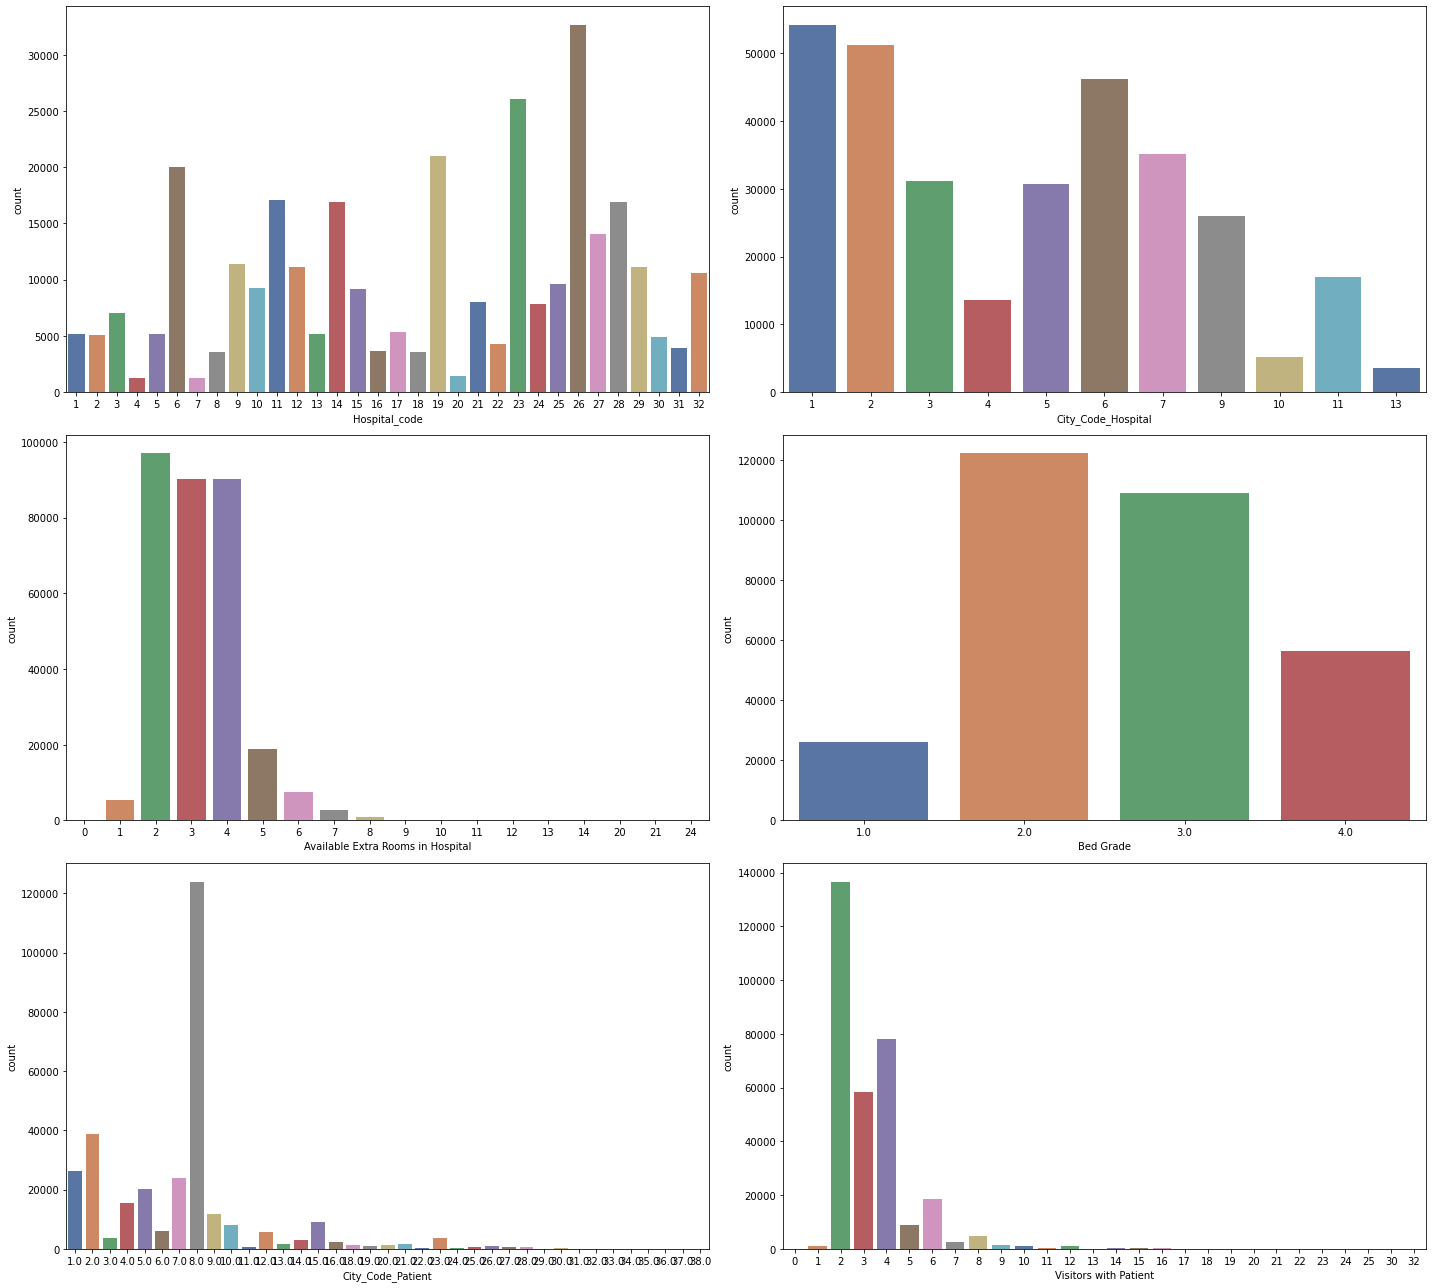

In [26]:
plt.figure(figsize=(20,18))
j=1
for i,columns in enumerate(num_cat_col):
    plt.subplot(3,2,j)
    sns.countplot(x=columns,data=df_train,palette='deep')
    j+=1
plt.tight_layout()

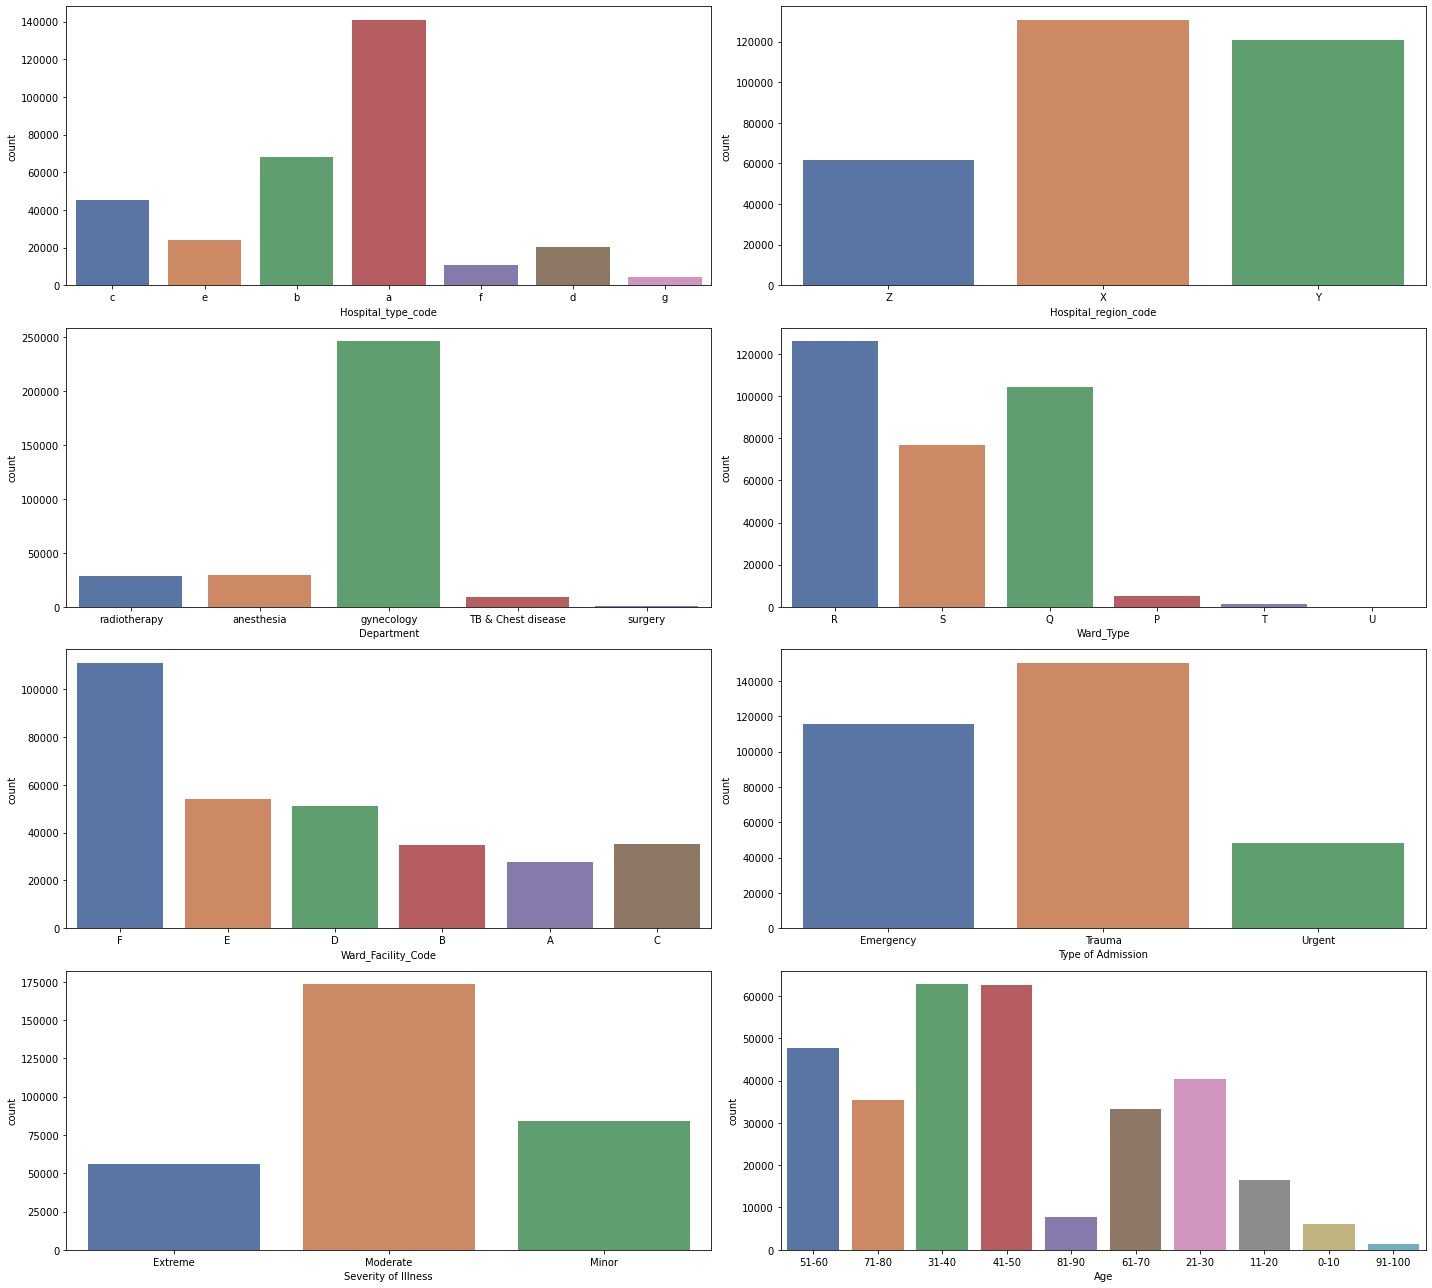

In [27]:
plt.figure(figsize=(20,18))
j=1
for i,columns in enumerate(cat_col):
    plt.subplot(4,2,j)
    sns.countplot(x=columns,data=df_train,palette='deep')
    j+=1
plt.tight_layout()

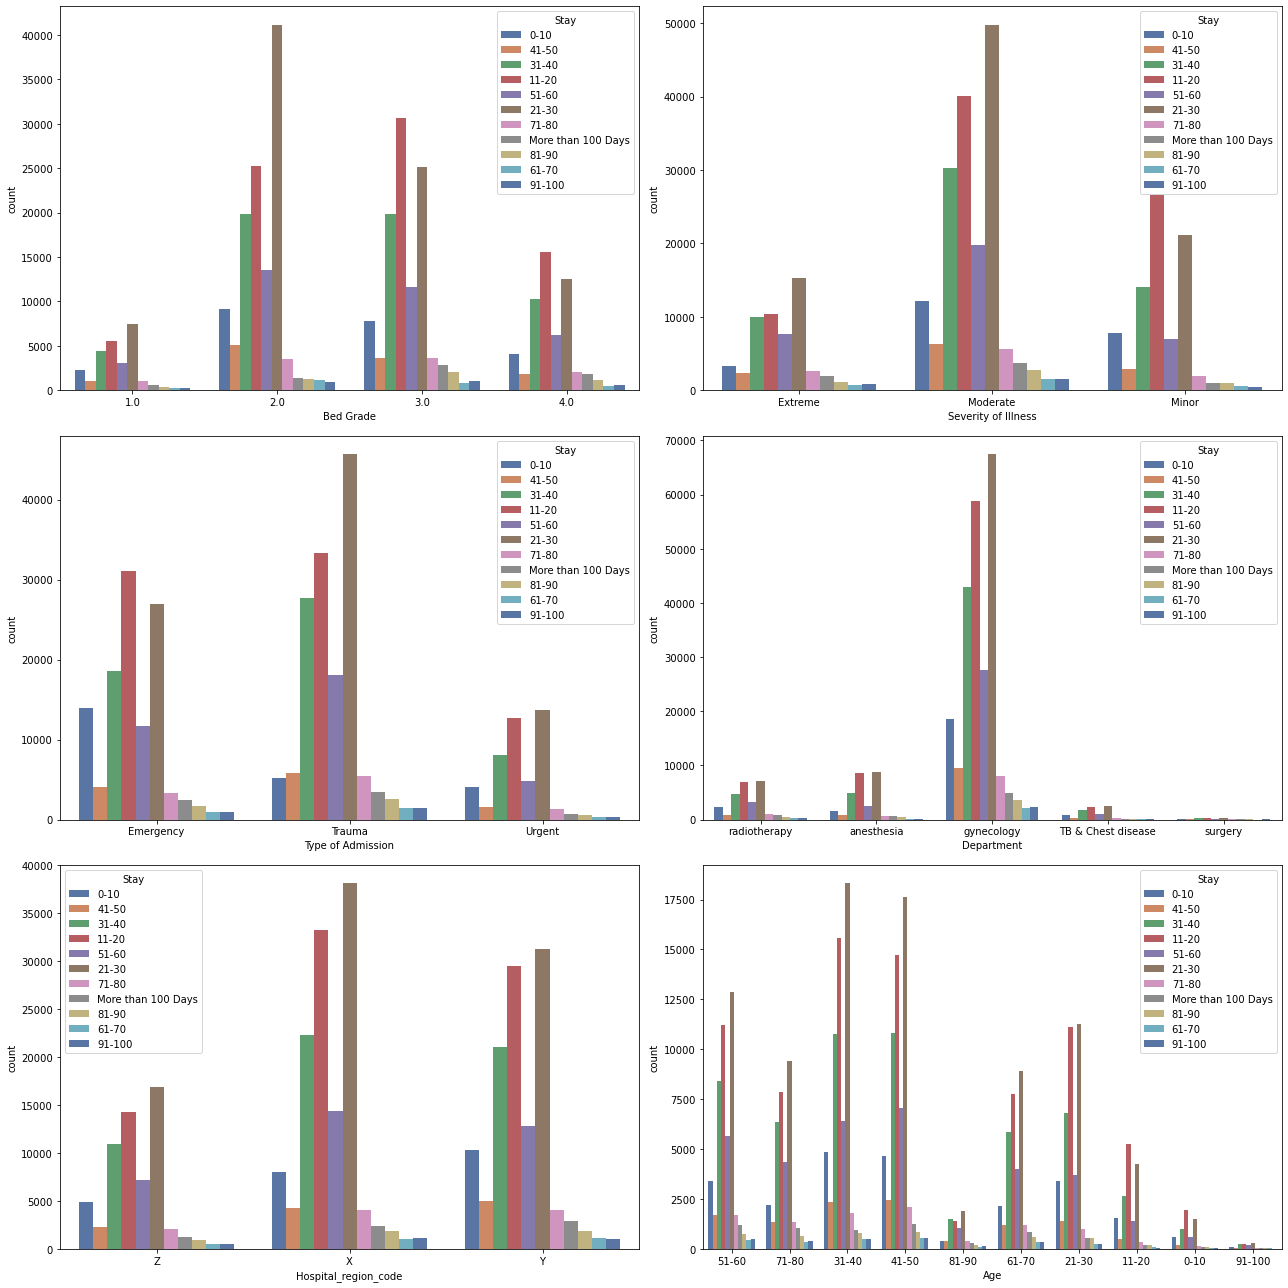

In [28]:
plt.figure(figsize=(18,18))
j=1
for i,columns in enumerate(['Bed Grade','Severity of Illness','Type of Admission','Department','Hospital_region_code','Age']):
    plt.subplot(3,2,j)
    sns.countplot(x=columns,data=df_train,palette='deep',hue='Stay')
    j+=1
plt.tight_layout()

Admission_Deposit                        ---->       7283 unique values


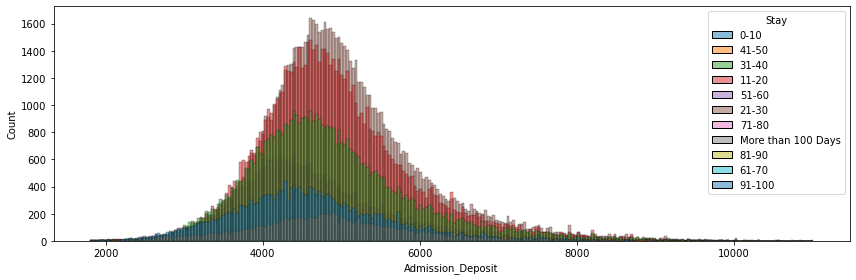

In [29]:
num_col=['Admission_Deposit']
print(f"{num_col[0]:40} ----> {df_train[num_col[0]].nunique():10} unique values")
plt.figure(figsize=(12,4))
sns.histplot(x=num_col[0],hue=target,data=df_train,palette='tab10')
plt.tight_layout()

# Label Encoding & New Feature Generation

In [11]:
# INPUT

hospital_type_map={
 'a': 0,
 'b': 1,
 'c': 2,
 'e': 3,
 'd': 4,
 'f': 5,
 'g': 6}

hospital_region_map = {'X': 0, 'Y': 1, 'Z': 2}

dep_map={'gynecology': 0,
 'anesthesia': 1,
 'radiotherapy': 2,
 'TB & Chest disease': 3,
 'surgery': 4}

ward_type_map ={'R': 0, 'Q': 1, 'S': 2, 'P': 3, 'T': 4, 'U': 5}
ward_fac_map ={'F':0, 'E': 1, 'D':2, 'C': 3, 'B': 4, 'A': 5}
admiss_map = {'Trauma': 0, 'Emergency': 1, 'Urgent': 2}

severity_map = {'Minor': 1,'Moderate': 2, 'Extreme': 3}
age_map = {'0-10': 5,
          '11-20': 15,
          '21-30': 25,
          '31-40': 35,
          '41-50': 45,
          '51-60': 55,
          '61-70': 65,
          '71-80': 75,
          '81-90': 85,
          '91-100': 95}

#OUTPUT
stay_map = {'21-30': 2,
 '11-20': 1,
 '31-40': 3,
 '51-60': 5,
 '0-10': 0,
 '41-50': 4,
 '71-80': 7,
 'More than 100 Days': 10,
 '81-90': 8,
 '91-100': 9,
 '61-70': 6}


In [31]:
df_train_copy = df_train.copy()
df_train_copy['Hospital_type_code'] = df_train_copy['Hospital_type_code'].map(hospital_type_map)
df_train_copy['Hospital_region_code'] = df_train_copy['Hospital_region_code'].map(hospital_region_map)
df_train_copy['Department'] = df_train_copy['Department'].map(dep_map)
df_train_copy['Ward_Type'] = df_train_copy['Ward_Type'].map(ward_type_map)
df_train_copy['Ward_Facility_Code'] = df_train_copy['Ward_Facility_Code'].map(ward_fac_map)
df_train_copy['Type of Admission'] = df_train_copy['Type of Admission'].map(admiss_map)
df_train_copy['Stay'] = df_train_copy['Stay'].map(stay_map)
df_train_copy['Severity of Illness'] = df_train_copy['Severity of Illness'].map(severity_map)
df_train_copy['Age'] = df_train_copy['Age'].map(age_map)
df_train_copy

case_id  Hospital_code  Hospital_type_code  City_Code_Hospital   
0             1              8                   2                   3  \
1             2              2                   2                   5   
2             3             10                   3                   1   
3             4             26                   1                   2   
4             5             26                   1                   2   
...         ...            ...                 ...                 ...   
318433   318434              6                   0                   6   
318434   318435             24                   0                   1   
318435   318436              7                   0                   4   
318436   318437             11                   1                   2   
318437   318438             19                   0                   7   

        Hospital_region_code  Available Extra Rooms in Hospital  Department   
0                          2                                  3           2  \
1                          2                                  2           2   
2                          0                                  2           1   
3                          1                                  2           2   
4                          1                                  2           2   
...                      ...                                ...         ...   
318433                     0                                  3           2   
318434                     0                                  2           1   
318435                     0                                  3           0   
318436                     1                                  3           1   
318437                     1                                  5           0   

        Ward_Type  Ward_Facility_Code  Bed Grade  patientid   
0               0                   0        2.0      31397  \
1               2                   0        2.0      31397   
2               2                   1        2.0      31397   
3               0                   2        2.0      31397   
4               2                   2        2.0      31397   
...           ...                 ...        ...        ...   
318433          1                   0        4.0      86499   
318434          1                   1        4.0        325   
318435          0                   0        4.0     125235   
318436          1                   2        3.0      91081   
318437          1                   3        2.0      21641   

        City_Code_Patient  Type of Admission  Severity of Illness   
0                     7.0                  1                    3  \
1                     7.0                  0                    3   
2                     7.0                  0                    3   
3                     7.0                  0                    3   
4                     7.0                  0                    3   
...                   ...                ...                  ...   
318433               23.0                  1                    2   
318434                8.0                  2                    2   
318435               10.0                  1                    1   
318436                8.0                  0                    1   
318437                8.0                  1                    1   

        Visitors with Patient  Age  Admission_Deposit  Stay  
0                           2   55             4911.0     0  
1                           2   55             5954.0     4  
2                           2   55             4745.0     3  
3                           2   55             7272.0     4  
4                           2   55             5558.0     4  
...                       ...  ...                ...   ...  
318433                      3   45             4144.0     1  
318434                      4   85             6699.0     3  
318435                    

In [32]:
df_train_copy.describe()

case_id  Hospital_code  Hospital_type_code  City_Code_Hospital   
count  313793.000000  313793.000000       313793.000000       313793.000000  \
mean   158937.911120      18.326419            1.244636            4.778169   
std     91939.506976       8.633613            1.515961            3.103237   
min         1.000000       1.000000            0.000000            1.000000   
25%     79271.000000      11.000000            0.000000            2.000000   
50%    158950.000000      19.000000            1.000000            5.000000   
75%    238399.000000      26.000000            2.000000            7.000000   
max    318438.000000      32.000000            6.000000           13.000000   

       Hospital_region_code  Available Extra Rooms in Hospital     Department   
count         313793.000000                      313793.000000  313793.000000  \
mean               0.780358                           3.196419       0.377462   
std                0.752329                           1.167924       0.799386   
min                0.000000                           0.000000       0.000000   
25%                0.000000                           2.000000       0.000000   
50%                1.000000                           3.000000       0.000000   
75%                1.000000                           4.000000       0.000000   
max                2.000000                          24.000000       4.000000   

           Ward_Type  Ward_Facility_Code      Bed Grade      patientid   
count  313793.000000       313793.000000  313793.000000  313793.000000  \
mean        0.888449            1.716616       2.622952   65743.029382   
std         0.860027            1.688914       0.872618   37978.083237   
min         0.000000            0.000000       1.000000       1.000000   
25%         0.000000            0.000000       2.000000   32833.000000   
50%         1.000000            1.000000       3.000000   65735.000000   
75%         2.000000            3.000000       3.000000   98472.000000   
max         5.000000            5.000000       4.000000  131624.000000   

       City_Code_Patient  Type of Admission  Severity of Illness   
count      313793.000000      313793.000000        313793.000000  \
mean            7.252447           0.674069             1.909909   
std             4.745243           0.724906             0.662730   
min             1.000000           0.000000             1.000000   
25%             4.000000           0.000000             1.000000   
50%             8.000000           1.000000             2.000000   
75%             8.000000           1.000000             2.000000   
max            38.000000           2.000000             3.000000   

       Visitors with Patient            Age  Admission_Deposit           Stay  
count          313793.000000  313793.000000      313793.000000  313793.000000  
mean                3.280857      46.276956        4881.893165       2.696003  
std                 1.761758      18.906076        1086.243945       2.147924  
min                 0.000000       5.000000        1800.000000       0.000000  
25%                 2.000000      35.000000        4188.000000       1.000000  
50%                 3.000000      45.000000        4742.000000       2.000000  
75%                 4.000000      55.000000        5410.000000       3.000000  
max                32.000000      95.000000       11008.000000      10.000000

<AxesSubplot:xlabel='Stay', ylabel='Count'>

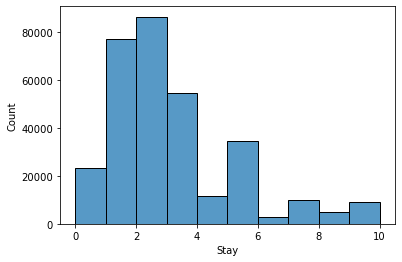

In [33]:
sns.histplot(df_train_copy['Stay'], bins=10)

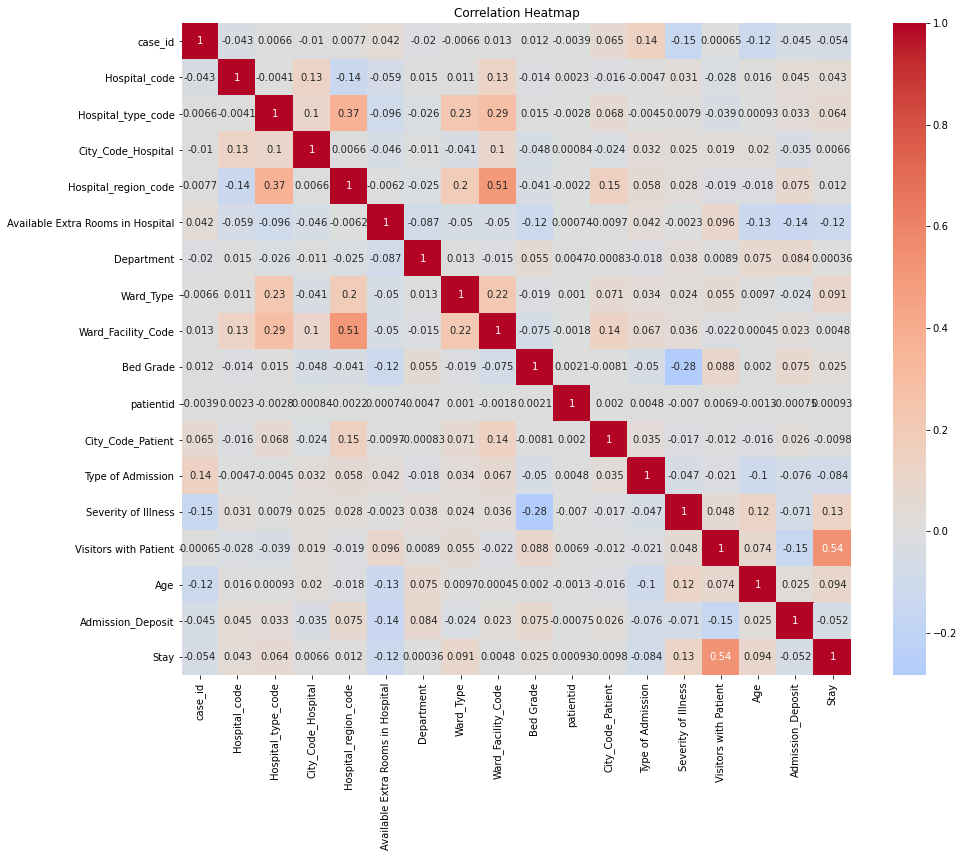

In [58]:
correlation_matrix = df_train_copy.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

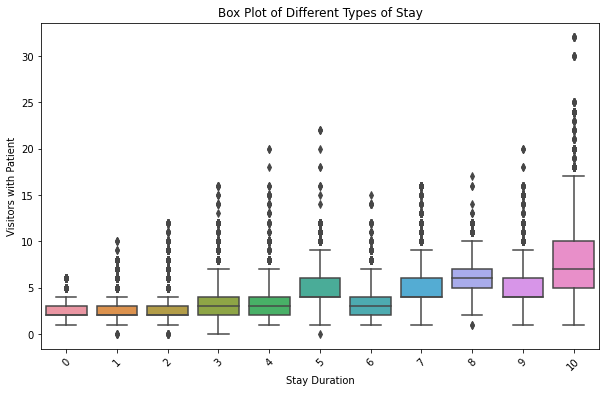

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stay', y='Visitors with Patient', data=df_train_copy)
plt.title('Box Plot of Different Types of Stay')
plt.xlabel('Stay Duration')
plt.ylabel('Visitors with Patient')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

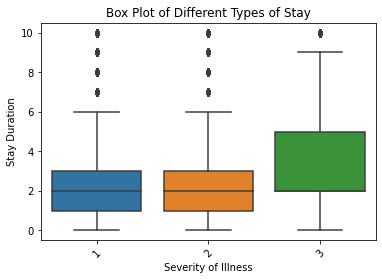

In [37]:
# plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity of Illness', y='Stay', data=df_train_copy)
plt.title('Box Plot of Different Types of Stay')
plt.xlabel('Severity of Illness')
plt.ylabel('Stay Duration')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

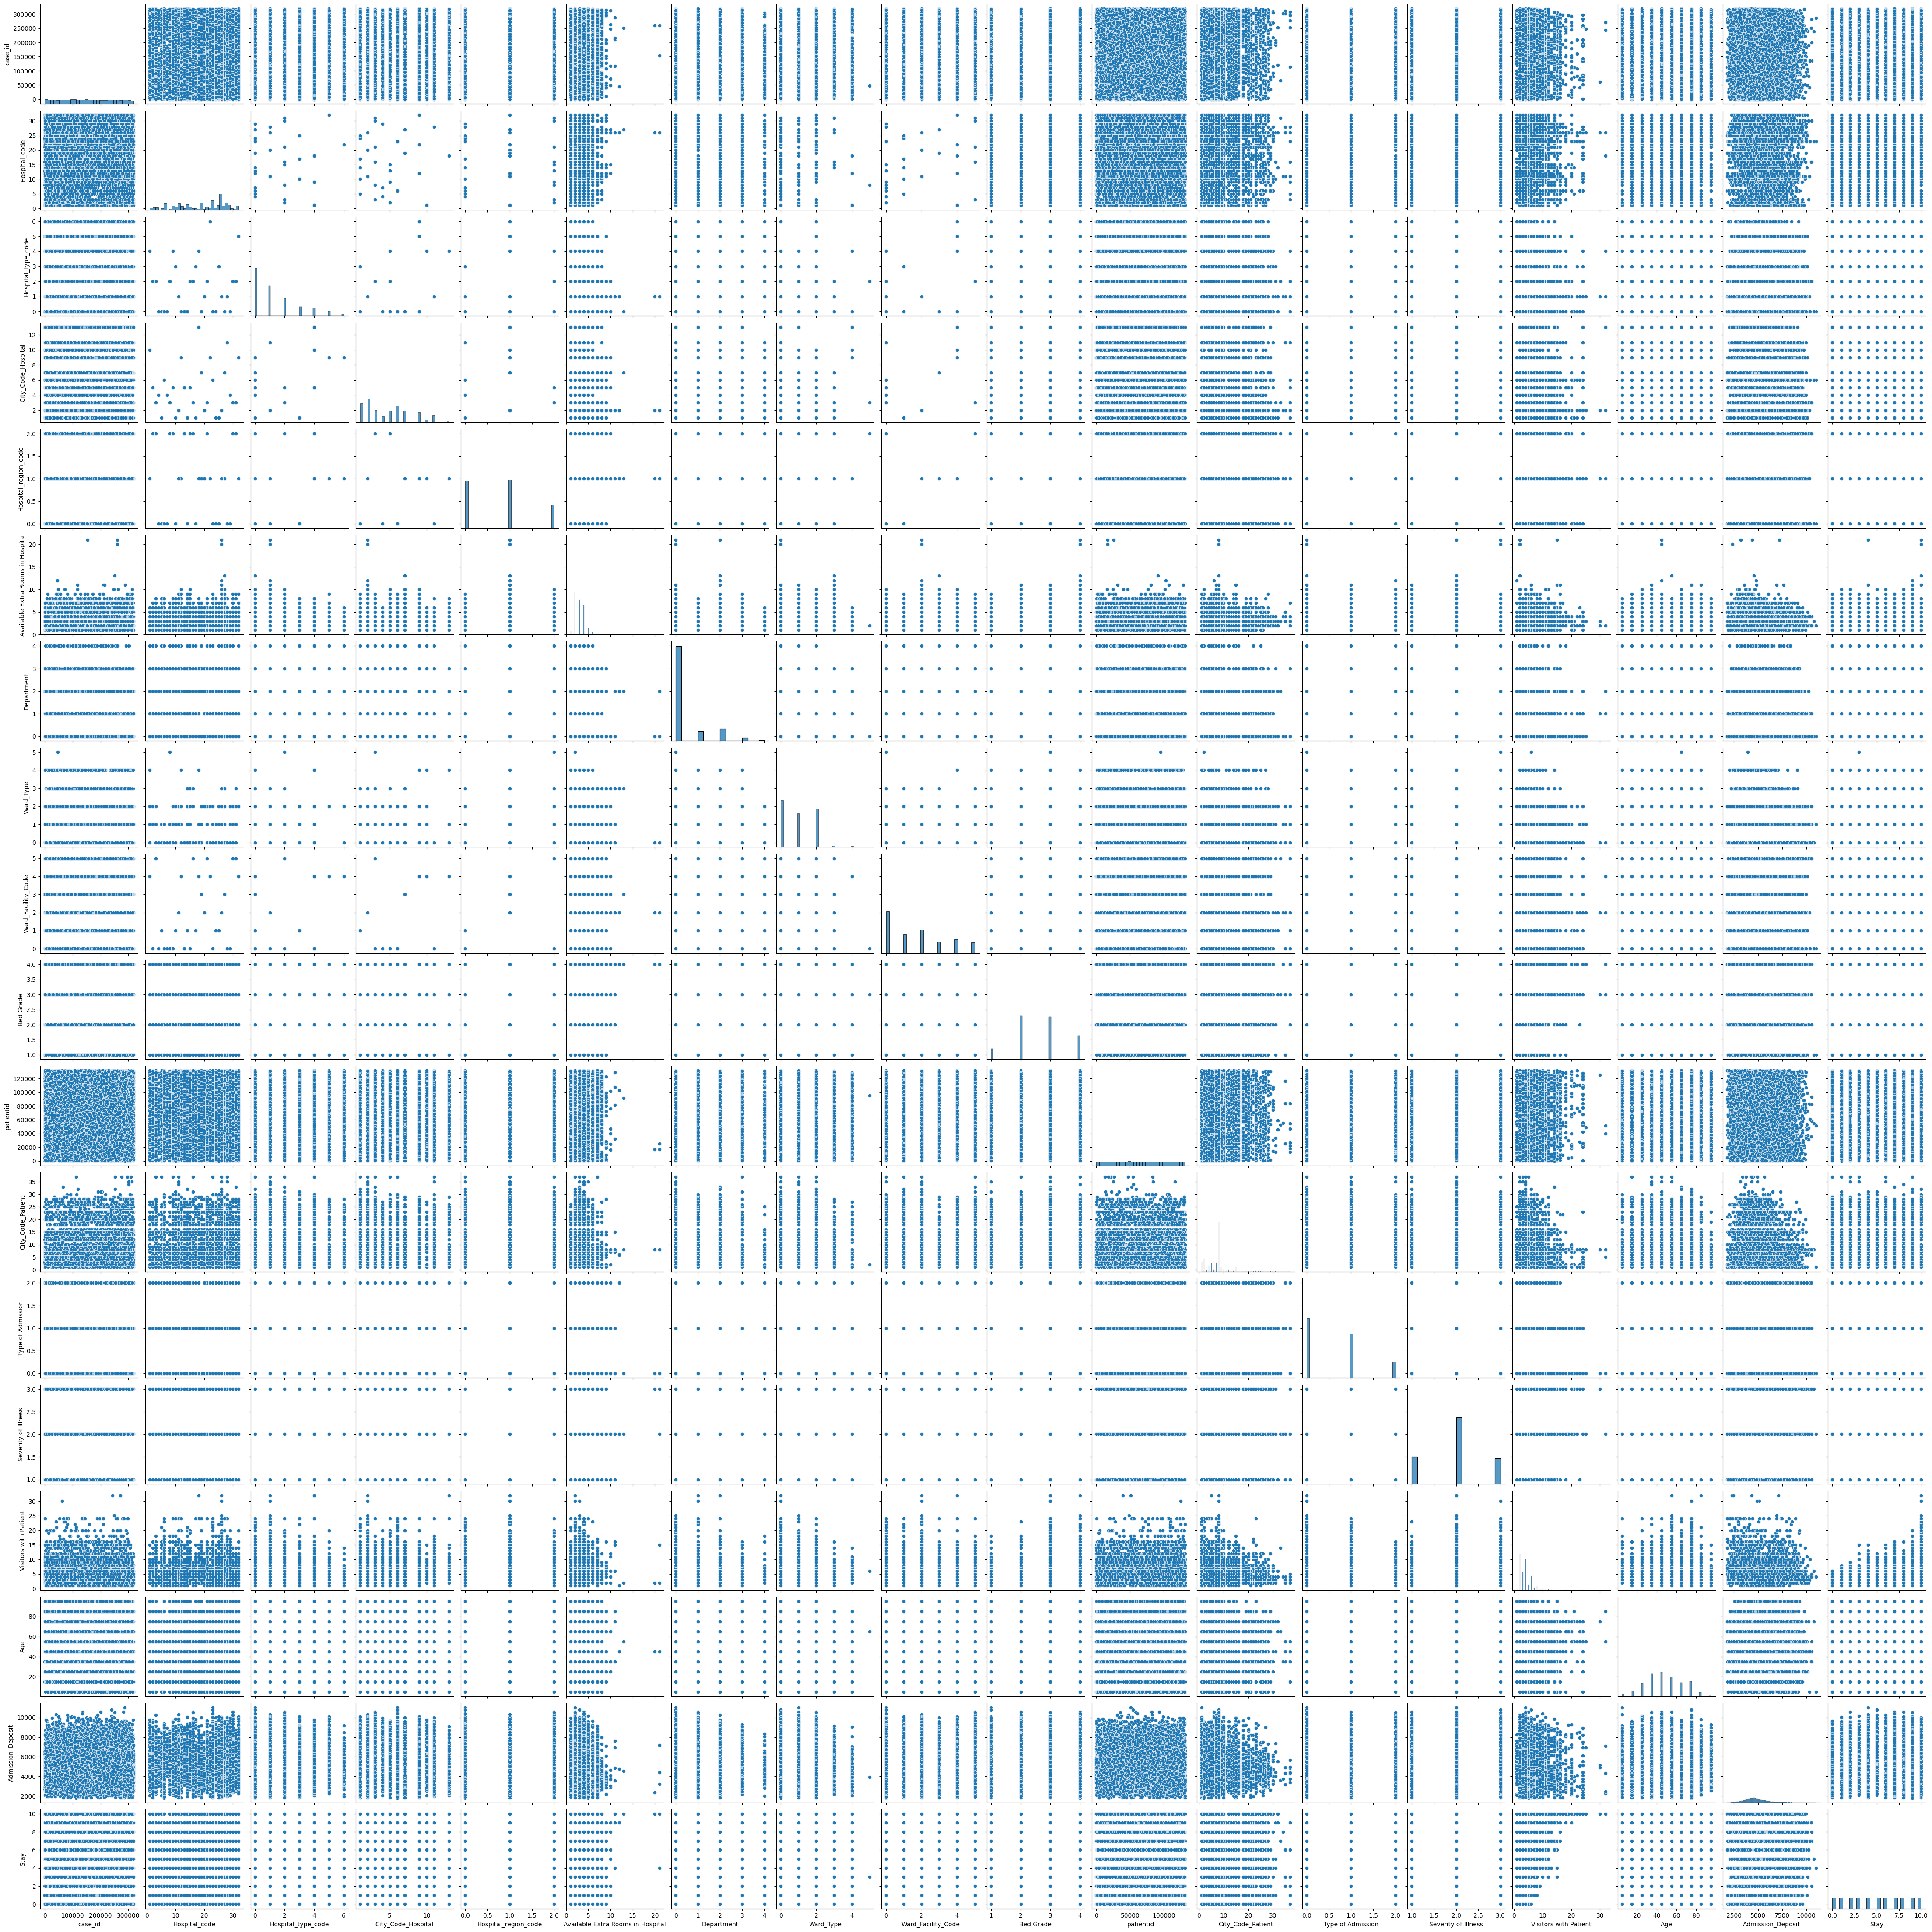

In [61]:
#sns.pairplot(df_sampled)

In [26]:
df['Hospital_type_code'] = df['Hospital_type_code'].map(hospital_type_map)
df['Hospital_region_code'] = df['Hospital_region_code'].map(hospital_region_map)
df['Department'] = df['Department'].map(dep_map)
df['Ward_Type'] = df['Ward_Type'].map(ward_type_map)
df['Ward_Facility_Code'] = df['Ward_Facility_Code'].map(ward_fac_map)
df['Type of Admission'] = df['Type of Admission'].map(admiss_map)
df['Stay'] = df['Stay'].map(stay_map)
df['Severity of Illness'] = df['Severity of Illness'].map(severity_map)
df['Age'] = df['Age'].map(age_map)

In [27]:
df['mean_Admission_Deposit_per_illness']=df.groupby(['Severity of Illness'])['Admission_Deposit'].transform('mean')
df['mean_Admission_Deposit_per_admission']=df.groupby(['Type of Admission'])['Admission_Deposit'].transform('mean')
df['mean_Admission_Deposit_per_bed']=df.groupby(['Bed Grade'])['Admission_Deposit'].transform('mean')
df['mean_Admission_Deposit_per_department']=df.groupby(['Department'])['Admission_Deposit'].transform('mean')
df['mean_Admission_Deposit_per_hosp']=df.groupby(['Hospital_code'])['Admission_Deposit'].transform('mean')

In [28]:
df['sum_Admission_Deposit_per_illness']=df.groupby(['Severity of Illness'])['Admission_Deposit'].transform('sum')
df['sum_Admission_Deposit_per_admission']=df.groupby(['Type of Admission'])['Admission_Deposit'].transform('sum')
df['sum_Admission_Deposit_per_bed']=df.groupby(['Bed Grade'])['Admission_Deposit'].transform('sum')
df['sum_Admission_Deposit_per_department']=df.groupby(['Department'])['Admission_Deposit'].transform('sum')
df['sum_Admission_Deposit_per_hosp']=df.groupby(['Hospital_code'])['Admission_Deposit'].transform('sum')

In [29]:
df['max_Admission_Deposit_per_illness']=df.groupby(['Severity of Illness'])['Admission_Deposit'].transform('max')
df['max_Admission_Deposit_per_admission']=df.groupby(['Type of Admission'])['Admission_Deposit'].transform('max')
df['max_Admission_Deposit_per_bed']=df.groupby(['Bed Grade'])['Admission_Deposit'].transform('max')
df['max_Admission_Deposit_per_department']=df.groupby(['Department'])['Admission_Deposit'].transform('max')
df['max_Admission_Deposit_per_hosp']=df.groupby(['Hospital_code'])['Admission_Deposit'].transform('max')

In [30]:
df['min_Admission_Deposit_per_illness']=df.groupby(['Severity of Illness'])['Admission_Deposit'].transform('min')
df['min_Admission_Deposit_per_admission']=df.groupby(['Type of Admission'])['Admission_Deposit'].transform('min')
df['min_Admission_Deposit_per_bed']=df.groupby(['Bed Grade'])['Admission_Deposit'].transform('min')
df['min_Admission_Deposit_per_department']=df.groupby(['Department'])['Admission_Deposit'].transform('min')
df['min_Admission_Deposit_per_hosp']=df.groupby(['Hospital_code'])['Admission_Deposit'].transform('min')

In [31]:
df['illness_count']=df.groupby('Hospital_code')['Severity of Illness'].transform('count')
df['bed_count']=df.groupby('Hospital_code')['Bed Grade'].transform('count')
df['room_count']=df.groupby('Hospital_code')['Available Extra Rooms in Hospital'].transform('count')
df['Department_count']=df.groupby('Hospital_code')['Department'].transform('count')
df['ward_count']=df.groupby('Hospital_code')['Ward_Type'].transform('count')
df['TOA_count']=df.groupby('Hospital_code')['Type of Admission'].transform('count')

In [32]:
df['mean_Admission_Deposit_per_patient_hosp']=df.groupby(['patientid','Hospital_code'])['Admission_Deposit'].transform('mean')
df['sum_Admission_Deposit_per_patient_hosp']=df.groupby(['patientid','Hospital_code'])['Admission_Deposit'].transform('sum')
df['max_Admission_Deposit_per_patient_hosp']=df.groupby(['patientid','Hospital_code'])['Admission_Deposit'].transform('max')
df['min_Admission_Deposit_per_patient_hosp']=df.groupby(['patientid','Hospital_code'])['Admission_Deposit'].transform('min')

In [33]:

df['mean_Visitors with Patient_per_patient']=df.groupby(['patientid'])['Visitors with Patient'].transform('mean')
df['sum_Visitors with Patient_per_patient']=df.groupby(['patientid'])['Visitors with Patient'].transform('sum')
df['max_Visitors with Patient_per_patient']=df.groupby(['patientid'])['Visitors with Patient'].transform('max')
df['min_Visitors with Patient_per_patient']=df.groupby(['patientid'])['Visitors with Patient'].transform('min')

In [34]:
df['unique_hospital_visited']=df.groupby('patientid')['Hospital_code'].transform('nunique')
df['unique_hospitaltype_visited']=df.groupby('patientid')['Hospital_type_code'].transform('nunique')
df['count_visited_same_hospital']=df.groupby(['patientid','Hospital_code'])['Hospital_code'].transform('count')

df['mean_Admission_Deposit_per_patient']=df.groupby(['patientid'])['Admission_Deposit'].transform('mean')
df['sum_Admission_Deposit_per_patient']=df.groupby(['patientid'])['Admission_Deposit'].transform('sum')
df['max_Admission_Deposit_per_patient']=df.groupby(['patientid'])['Admission_Deposit'].transform('max')
df['min_Admission_Deposit_per_patient']=df.groupby(['patientid'])['Admission_Deposit'].transform('min')

df['mean_visitors_per_patient']=df.groupby(['patientid'])['Visitors with Patient'].transform('mean')
df['unique city']=df.groupby('patientid')['City_Code_Hospital'].transform('nunique')
df['unique illness type']=df.groupby('patientid')['Severity of Illness'].transform('nunique')
df['unique admission type']=df.groupby('patientid')['Type of Admission'].transform('nunique')

df['mean_Admission_Deposit_per_patient_in_same_hospital']=df.groupby(['patientid','Hospital_code'])['Admission_Deposit'].transform('mean')

In [35]:
df['total_no_of_patients_in_hospital']=df.groupby('Hospital_code')['patientid'].transform('count')
df['total_no_of_patients_in_hospital_from_same_city']=df.groupby(['Hospital_code','City_Code_Patient'])['patientid'].transform('count')
df['total_no_of_patients_in_patientcity']=df.groupby('City_Code_Patient')['patientid'].transform('count')
df['total_no_of_patients_in_hospitalcity']=df.groupby('City_Code_Hospital')['patientid'].transform('count')

In [36]:
df['number_of_time_patient_visited']=df.groupby('patientid')['patientid'].transform('count')
df['Total_Hospitals_in_city']=df.groupby('City_Code_Hospital')['Hospital_code'].transform('nunique')
df['Total_Hospitals_in_city_of_same_type']=df.groupby(['City_Code_Hospital','Hospital_type_code'])['Hospital_code'].transform('nunique')

In [37]:
df['total_no_of_patients_per_Department']=df.groupby('Department')['patientid'].transform('count')
df['total_no_of_patients_per_Severity of Illness']=df.groupby('Severity of Illness')['patientid'].transform('count')
df['Total_Hospitals_in_region']=df.groupby('Hospital_region_code')['patientid'].transform('count')
df['total_no_of_patients_in_hospitalward']=df.groupby(['Hospital_code','Ward_Type'])['patientid'].transform('count')
df['total_no_of_patients_in_hospitaldepartment']=df.groupby(['Hospital_code','Department'])['patientid'].transform('count')
df['total_no_of_patients_in_hospitalBedGrade']=df.groupby(['Hospital_code','Bed Grade'])['patientid'].transform('count')
df['total_no_of_patients_in_hospitalSeverityofIllness']=df.groupby(['Hospital_code','Type of Admission'])['patientid'].transform('count')
df['unique_patientcity_in_hospital']=df.groupby('Hospital_code')['City_Code_Patient'].transform('nunique')
df['Average_deposit']=df.groupby('Hospital_code')['Available Extra Rooms in Hospital'].transform('mean')
df['Total_Hospitals_in_patientcity']=df.groupby('City_Code_Patient')['Hospital_code'].transform('nunique')
df['Total_Hospitals_in_region']=df.groupby('Hospital_region_code')['Hospital_code'].transform('nunique')

In [38]:
df["RANK"] = df.groupby("patientid")['patientid'].rank(method="first", ascending=True)
df["RANK_avg"] = df.groupby("patientid")['patientid'].rank(method="average", ascending=True)
df["RANK_max"] = df.groupby("patientid")['patientid'].rank(method="max", ascending=True)
df["RANK_min"] = df.groupby("patientid")['patientid'].rank(method="min", ascending=True)
df["RANK_DIFF"] = df['RANK_max'] - df['RANK_min']
df["RANK_Type_Admission"] = df.groupby(['patientid','Type of Admission'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_City_Code"] = df.groupby(['patientid','City_Code_Hospital'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_hosp_Code"] = df.groupby(['patientid','Hospital_code'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_hosp_type_Code"] = df.groupby(['patientid','Hospital_type_code'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_rooms"] = df.groupby(['patientid','Available Extra Rooms in Hospital'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_Department"] = df.groupby(['patientid','Department'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_Ward_Type"] = df.groupby(['patientid','Ward_Type'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_Ward_Facility_Code"] = df.groupby(['patientid','Ward_Facility_Code'])['patientid'].rank(method='first',ascending=True)
df["RANK_Type_Hospital_region_code"] = df.groupby(['patientid','Hospital_region_code'])['patientid'].rank(method='first',ascending=True)
df['Rank_City_Code_Patient'] = df.groupby(['patientid','City_Code_Patient'])['patientid'].rank(method='first',ascending=True)
df['Rank_City_Code_Vist'] = df.groupby(['patientid','Visitors with Patient'])['patientid'].rank(method='first',ascending=True)
df['Rank_ill+admiss'] = df.groupby(['patientid','Type of Admission','Severity of Illness'])['patientid'].rank(method='first',ascending=True)
df['Rank_ill+admiss_max'] = df.groupby(['patientid','Type of Admission','Severity of Illness'])['patientid'].rank(method='max',ascending=True)
df['Rank_ill+admiss_min'] = df.groupby(['patientid','Type of Admission','Severity of Illness'])['patientid'].rank(method='min',ascending=True)
df['Rank_ill+admiss_avg'] = df.groupby(['patientid','Type of Admission','Severity of Illness'])['patientid'].rank(method='average',ascending=True)
df['Rank_ill+admiss_diff'] = df['Rank_ill+admiss_max'] - df['Rank_ill+admiss_min']
cols_rank = ['Type of Admission','City_Code_Hospital','Hospital_code','Hospital_type_code','Available Extra Rooms in Hospital','Department','Ward_Type','Ward_Facility_Code',
             'Hospital_region_code','City_Code_Patient','Visitors with Patient']
for i in cols_rank:
    df[f"RANK_{i}_min"] = df.groupby(['patientid',i])['patientid'].rank(method='min',ascending=True)
    df[f"RANK_{i}_max"] = df.groupby(['patientid',i])['patientid'].rank(method='max',ascending=True)
    df[f"RANK_{i}_avg"] = df.groupby(['patientid',i])['patientid'].rank(method='average',ascending=True)
    df[f'diff_{i}_max_min'] = df[f"RANK_{i}_max"] -  df[f"RANK_{i}_min"]

<ipython-input-38-7d42b742e258>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Rank_ill+admiss_avg'] = df.groupby(['patientid','Type of Admission','Severity of Illness'])['patientid'].rank(method='average',ascending=True)
<ipython-input-38-7d42b742e258>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Rank_ill+admiss_diff'] = df['Rank_ill+admiss_max'] - df['Rank_ill+admiss_min']
<ipython-input-38-7d42b742e258>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

<ipython-input-38-7d42b742e258>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"RANK_{i}_max"] = df.groupby(['patientid',i])['patientid'].rank(method='max',ascending=True)
<ipython-input-38-7d42b742e258>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"RANK_{i}_avg"] = df.groupby(['patientid',i])['patientid'].rank(method='average',ascending=True)
<ipython-input-38-7d42b742e258>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<ipython-input-38-7d42b742e258>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"RANK_{i}_avg"] = df.groupby(['patientid',i])['patientid'].rank(method='average',ascending=True)
<ipython-input-38-7d42b742e258>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'diff_{i}_max_min'] = df[f"RANK_{i}_max"] -  df[f"RANK_{i}_min"]


In [40]:
df = df.dropna()

In [41]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

<ipython-input-41-387217488018>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns={'train_or_test'},axis=1,inplace=True)


In [42]:
x=train.drop(columns={'case_id','Stay'},axis=1)
y=train.loc[:,['Stay']]
test=test.drop(columns={'case_id','Stay'},axis=1)

# MODEL TRAINING ON SAMPLE DATA

In [38]:
from imblearn.under_sampling import RandomUnderSampler
# Separate features and target
X = df_train_copy.drop(columns=['Stay'])
y = df_train_copy['Stay']

# Set the desired sample size for downsampled categories
desired_sample_size = 2500

# Create a RandomUnderSampler instance with the desired sample size
under_sampler = RandomUnderSampler(sampling_strategy={category: desired_sample_size for category in y.unique()})

# Apply the under-sampling to balance the dataset
X_resampled, y_resampled = under_sampler.fit_resample(X, y)
df_sampled = pd.concat([X_resampled, y_resampled], axis=1)
# Display the resampled class distribution
print(pd.Series(y_resampled).value_counts())


Stay
0     2500
1     2500
2     2500
3     2500
4     2500
5     2500
6     2500
7     2500
8     2500
9     2500
10    2500
Name: count, dtype: int64


In [70]:
df_train_copy.Stay.value_counts()

Stay
2     86316
1     77095
3     54312
5     34463
0     23250
4     11541
7     10096
10     6548
8      4761
9      2713
6      2698
Name: count, dtype: int64

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

NameError: name 'X_resampled' is not defined

### Model 1

In [49]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'criterion': ['gini', 'entropy']
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='accuracy', cv=3)
rf_grid_search.fit(X_train, y_train)

# Get the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

KeyboardInterrupt: 

In [176]:
import joblib
model_filename = 'RF.pkl'
joblib.dump(best_rf_model, model_filename)

['RF.pkl']

### Model 2

In [47]:
# Extra Trees
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train, y_train)


# Hyperparameter tuning for Extra Trees
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
    'criterion': ['gini', 'entropy']
}

et_grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid_et, scoring='accuracy', cv=3)
et_grid_search.fit(X_train, y_train)

# Get the best Extra Trees model
best_et_model = et_grid_search.best_estimator_

In [49]:
import joblib
model_filename = 'ET.pkl'
joblib.dump(best_et_model, model_filename)

['ET.pkl']

### Model 3

In [50]:
# AdaBoost Classifier
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Hyperparameter tuning for AdaBoost Classifier
param_grid_ada = {
    'n_estimators': [50, 100, 150]
    'learning_rate': [0.01, 0.1, 0.2]
}

ada_grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid_ada, scoring='accuracy', cv=3)
ada_grid_search.fit(X_train, y_train)

# Get the best AdaBoost model
best_ada_model = ada_grid_search.best_estimator_

In [51]:
model_filename = 'ADA.pkl'
joblib.dump(best_ada_model, model_filename)

['ADA.pkl']

### Model 4

In [52]:
# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)


# Hyperparameter tuning for XGBoost Classifier
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='accuracy', cv=3)
xgb_grid_search.fit(X_train, y_train)

# Get the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

In [53]:
model_filename = 'xgb.pkl'
joblib.dump(best_xgb_model, model_filename)

['xgb.pkl']

### Model 5

In [338]:
%%capture
!pip install scikeras
from keras.models import Sequential
from keras.layers import Dense, Dropout

def standard_nn():
    model = Sequential()
    model.add(Dense(128, input_dim=X_encoded_train.shape[1], activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(11, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [349]:
estimator = KerasClassifier(model=standard_nn, epochs=50, batch_size=10000, verbose=1)
kfold = KFold(n_splits=3, shuffle=True)

In [350]:
kfold = KFold(n_splits=3, shuffle=True)

In [351]:
results = cross_val_score(estimator, X_encoded_train, Y_encoded_train, cv=kfold, verbose = 1, 
                          fit_params={'validation_data': (X_encoded_val, Y_encoded_val)})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
4/4 [==============================] - 2s 457ms/step - loss: 2.2661 - accuracy: 0.1959 - val_loss: 1.9984 - val_accuracy: 0.2489
Epoch 2/50
4/4 [==============================] - 2s 418ms/step - loss: 1.9718 - accuracy: 0.2624 - val_loss: 1.9221 - val_accuracy: 0.2834
Epoch 3/50
4/4 [==============================] - 2s 417ms/step - loss: 1.9483 - accuracy: 0.2739 - val_loss: 1.8960 - val_accuracy: 0.2939
Epoch 4/50
4/4 [==============================] - 2s 405ms/step - loss: 1.9109 - accuracy: 0.2774 - val_loss: 1.8745 - val_accuracy: 0.3129
Epoch 5/50
4/4 [==============================] - 2s 405ms/step - loss: 1.8917 - accuracy: 0.2961 - val_loss: 1.8678 - val_accuracy: 0.3158
Epoch 6/50
4/4 [==============================] - 2s 415ms/step - loss: 1.8828 - accuracy: 0.3027 - val_loss: 1.8529 - val_accuracy: 0.3153
Epoch 7/50
4/4 [==============================] - 2s 423ms/step - loss: 1.8694 - accuracy: 0.3056 - val_loss: 1.8383 - val_accuracy: 0.3180
Epoch 8/50
4/4 [====

KeyboardInterrupt: 

In [ ]:
print("Baseline average accuracy and standard deviation: %.2f%% (%.2f%%)"
      % (results.mean()*100, results.std()*100))

In [ ]:
estimator.fit(X_encoded_train, Y_encoded_train)

In [345]:
import joblib
model_filename = 'NN_full_ethic.pkl'
joblib.dump(estimator, model_filename)

['NN_full_ethic.pkl']

In [56]:
import joblib
best_rf_model = joblib.load('RF_full.pkl')
best_et_model = joblib.load('ET_full.pkl')
best_ada_model = joblib.load('CBC_full.pkl')

In [ ]:
best_xgb_model = joblib.load('NN.pkl')

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluation functions
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass precision
    recall = recall_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass recall
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multiclass F1 score
    return cm, accuracy, precision, recall, f1

# Evaluate models
rf_train_cm, rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1 = evaluate_model(best_rf_model, X_train, y_train)
rf_val_cm, rf_val_accuracy, rf_val_precision, rf_val_recall, rf_val_f1 = evaluate_model(best_rf_model, X_val, y_val)

# gbt_train_cm, gbt_train_accuracy, gbt_train_precision, gbt_train_recall, gbt_train_f1 = evaluate_model(best_gbt_model, X_train, y_train)
# gbt_val_cm, gbt_val_accuracy, gbt_val_precision, gbt_val_recall, gbt_val_f1 = evaluate_model(best_gbt_model, X_val, y_val)

et_train_cm, et_train_accuracy, et_train_precision, et_train_recall, et_train_f1 = evaluate_model(best_et_model, X_train, y_train)
et_val_cm, et_val_accuracy, et_val_precision, et_val_recall, et_val_f1 = evaluate_model(best_et_model, X_val, y_val)

ada_train_cm, ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1 = evaluate_model(best_ada_model, X_train, y_train)
ada_val_cm, ada_val_accuracy, ada_val_precision, ada_val_recall, ada_val_f1 = evaluate_model(best_ada_model, X_val, y_val)

# xgb_train_cm, xgb_train_accuracy, xgb_train_precision, xgb_train_recall, xgb_train_f1 = evaluate_model(best_xgb_model, X_train, y_train)
# xgb_val_cm, xgb_val_accuracy, xgb_val_precision, xgb_val_recall, xgb_val_f1 = evaluate_model(best_xgb_model, X_val, y_val)


In [49]:
# Define the training and validation metrics for each model
rf_training_metrics = [rf_train_accuracy, rf_train_precision, rf_train_recall, rf_train_f1]
rf_validation_metrics = [rf_val_accuracy, rf_val_precision, rf_val_recall, rf_val_f1]

# gbt_training_metrics = [gbt_train_accuracy, gbt_train_precision, gbt_train_recall, gbt_train_f1]
# gbt_validation_metrics = [gbt_val_accuracy, gbt_val_precision, gbt_val_recall, gbt_val_f1]

et_training_metrics = [et_train_accuracy, et_train_precision, et_train_recall, et_train_f1]
et_validation_metrics = [et_val_accuracy, et_val_precision, et_val_recall, et_val_f1]

ada_training_metrics = [ada_train_accuracy, ada_train_precision, ada_train_recall, ada_train_f1]
ada_validation_metrics = [ada_val_accuracy, ada_val_precision, ada_val_recall, ada_val_f1]

# xgb_training_metrics = [xgb_train_accuracy, xgb_train_precision, xgb_train_recall, xgb_train_f1]
# xgb_validation_metrics = [xgb_val_accuracy, xgb_val_precision, xgb_val_recall, xgb_val_f1]


training_metrics = [rf_training_metrics, et_training_metrics, ada_training_metrics]
validation_metrics = [rf_validation_metrics, et_validation_metrics, ada_validation_metrics]

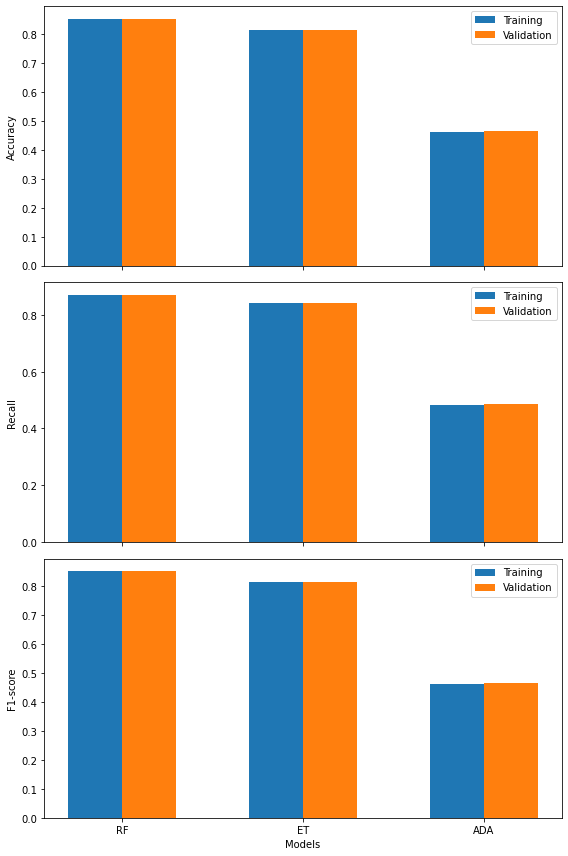

In [50]:
# Model names and metrics
model_names = ['RF', 'ET', 'ADA']
metrics = ['Accuracy', 'Recall', 'F1-score']

bar_width = 0.3

# Create positions for the bars
positions = np.arange(len(model_names))

# Plot bar plots for each evaluation metric
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 12), sharex=True)
for i, metric in enumerate(metrics):
    axs[i].bar(positions - bar_width/2, [training_metrics[j][i] for j in range(len(model_names))],
               width=bar_width, label='Training')
    axs[i].bar(positions + bar_width/2, [validation_metrics[j][i] for j in range(len(model_names))],
               width=bar_width, label='Validation')
    axs[i].set_xticks(positions)
    axs[i].set_xticklabels(model_names)
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.xlabel('Models')

plt.tight_layout()
plt.show()

# MODEL TRAINING WITH COMPLETE DATA

### MODEL 1

In [289]:
%%time
err = []
y_pred_tot_lgm = np.zeros((len(test), 11))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = CatBoostClassifier(n_estimators=10000,
                       random_state=2020,
                       eval_metric='Accuracy',
                       learning_rate=0.08,
                       depth=8,
                       bagging_temperature=0.3,
                       task_type='GPU'
                       #num_leaves=64

                       )
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=100,verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val,pred_y))
    err.append(accuracy_score(y_val,pred_y))
#     y_pred_tot_lgm+= m.predict_proba(test)
    i = i + 1
# y_pred_tot_lgm=y_pred_tot_lgm/10
sum(err)/10

0:	learn: 0.3959742	test: 0.3964252	best: 0.3964252 (0)	total: 80.8ms	remaining: 13m 27s
200:	learn: 0.4599942	test: 0.4341463	best: 0.4360454 (169)	total: 15.8s	remaining: 12m 48s
400:	learn: 0.4813439	test: 0.4377211	best: 0.4384286 (394)	total: 30.5s	remaining: 12m 11s
bestTest = 0.4387264941
bestIteration = 450
Shrink model to first 451 iterations.
1  err_lgm:  0.43872649413517034
0:	learn: 0.3963300	test: 0.3940421	best: 0.3940421 (0)	total: 79.4ms	remaining: 13m 14s
200:	learn: 0.4597832	test: 0.4381679	best: 0.4384658 (196)	total: 15.8s	remaining: 12m 52s
400:	learn: 0.4828375	test: 0.4422640	best: 0.4423385 (381)	total: 30.9s	remaining: 12m 18s
bestTest = 0.4427480916
bestIteration = 453
Shrink model to first 454 iterations.
2  err_lgm:  0.44274809160305345
0:	learn: 0.3961811	test: 0.3953081	best: 0.3953081 (0)	total: 80.5ms	remaining: 13m 24s
200:	learn: 0.4592619	test: 0.4401787	best: 0.4409980 (196)	total: 15.9s	remaining: 12m 53s
400:	learn: 0.4815052	test: 0.4429715	best:

0.44181422740400433

In [291]:
import joblib
model_filename = 'CBC_full_outliers.pkl'
joblib.dump(m, model_filename)

['CBC_full_outliers.pkl']

### MODEL 2

In [292]:
%%time
err = []
y_pred_tot_extra_trees = np.zeros((len(test), 11))  # Corrected array name

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    # Convert y_train to a 1-dimensional array using ravel()
    y_train = y_train.values.ravel()

    m3 = ExtraTreesClassifier(n_estimators=100, max_depth=20,n_jobs=-1)
    m3.fit(x_train, y_train)
    pred_y = m3.predict(x_val)
    y_val = y_val.values.ravel()
    print(i, " err_extra_trees: ", accuracy_score(y_val, pred_y))
    err.append(accuracy_score(y_val, pred_y))
#     y_pred_tot_extra_trees += m3.predict_proba(test)
    i += 1
# y_pred_tot_extra_trees = y_pred_tot_extra_trees / 10
sum(err) / 10


1  err_extra_trees:  0.4180227145782908
2  err_extra_trees:  0.42163470489666727


KeyboardInterrupt: 

In [219]:
import joblib
model_filename = 'ET_full.pkl'
joblib.dump(m3, model_filename)

['ET_full.pkl']

### MODEL 3

In [220]:
%%time
err = []
y_pred_tot_rf = np.zeros((len(test), 11))  # Corrected array name

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(x, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Convert y_train to a 1-dimensional array using ravel()
    y_train = y_train.values.ravel()
    
    m2 = RandomForestClassifier(n_estimators=300,
                       max_depth=20,
                       max_features='sqrt',  # Change to 'sqrt'
                       n_jobs=-1)
    m2.fit(x_train, y_train)
    pred_y = m2.predict(x_val)
    print(i, " err_rf: ", accuracy_score(y_val, pred_y))
    err.append(accuracy_score(y_val, pred_y))
#     y_pred_tot_rf += m2.predict_proba(test) 
    i = i + 1
# y_pred_tot_rf = y_pred_tot_rf / 10
sum(err) / 10


1  err_rf:  0.434257488846399
2  err_rf:  0.4375717017208413
3  err_rf:  0.43804971319311664
4  err_rf:  0.4358010134166162
5  err_rf:  0.43366582746422766
6  err_rf:  0.4364383823576277
7  err_rf:  0.4385098314159151
8  err_rf:  0.43870104209821853
9  err_rf:  0.44099557028585995
10  err_rf:  0.4387966474393703
Wall time: 21min 31s


0.43727872182381927

In [221]:
import joblib
model_filename = 'RF_full.pkl'
joblib.dump(m2, model_filename)

['RF_full.pkl']

### MODEL 4

In [385]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on your training data and transform both training and validation data
x_scaled = scaler.fit_transform(x)

In [391]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
err = []
y_pred_tot_rf = np.zeros((len(test), 11))  # Corrected array name

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(x_scaled, y):
    x_train, x_val = x.iloc[train_index], x.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Convert y_train to a 1-dimensional array using ravel()
    y_train = to_categorical(y_train, num_classes=11)
    y_val= to_categorical(y_val, num_classes=11)
    
    
    m4 = Sequential()
    m4.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
    m4.add(Dense(256, activation='relu'))
    m4.add(Dropout(0.2)) 
    m4.add(Dense(512, activation='relu'))
    m4.add(Dropout(0.4))
    m4.add(Dense(11, activation='softmax'))
    m4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
    
    estimator = KerasClassifier(model=m4, epochs=10, batch_size=50000, verbose=0)
    results = cross_val_score(estimator, x_train, y_train, verbose = 1, 
                          fit_params={'validation_data': (x_val, y_val)}, n_jobs=-1)
    estimator.fit(x_train, y_train)
    pred_y = estimator.predict(x_val)
    print(i, " err_rf: ", accuracy_score(y_val, pred_y))
    err.append(accuracy_score(y_val, pred_y))
#     y_pred_tot_rf += m2.predict_proba(test) 
    i = i + 1
# y_pred_tot_rf = y_pred_tot_rf / 10
sum(err) / 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmp1fsggzc8\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmpuzfnoyri\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmpe1c13l4a\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmpff5looi8\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmp0obaf1xn\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmpv2kawvms\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmp43loxn47\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmp2d0h7mw3\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmpdzfzinbh\assets
INFO:tensorflow:Assets written to: C:\Users\naikss\AppData\Local\Temp\tmp3h8a560y\assets


KeyboardInterrupt: 

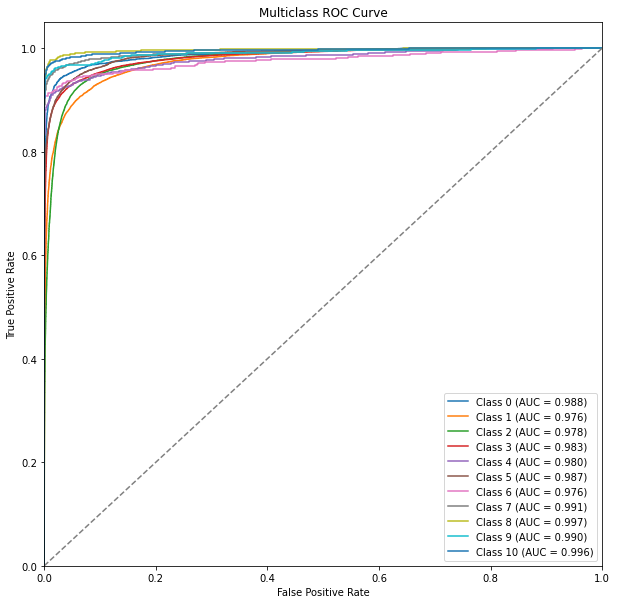

In [64]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_pred_probs = best_rf_model.predict_proba(X_val)

# Example: Replace this with the number of classes in your problem
K = 11

# Convert true labels to one-hot encoded format
y_val_bin = label_binarize(y_val, classes=np.arange(K))

# Initialize a figure
plt.figure(figsize=(10, 10))

# Calculate ROC curve and AUC for each class
for i in range(K):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

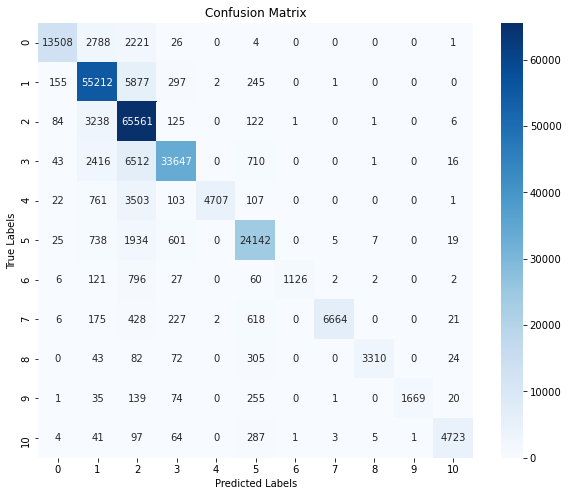

In [63]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rf_train_cm, annot=True, fmt="d", cmap="Blues", square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [89]:
# Feature name to drop
feature_importances = best_rf_model.feature_importances_
feature_names = list(X_train.columns)  # Convert Index object to list

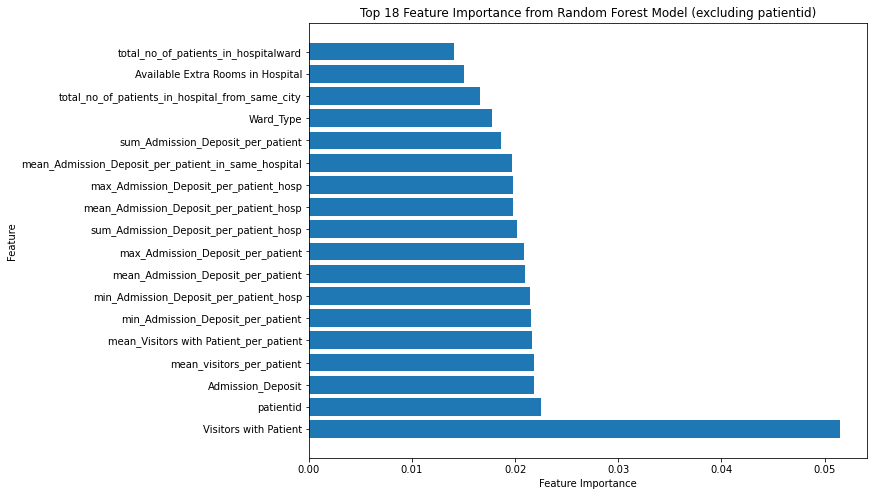

In [90]:

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices if i < len(feature_names)]

# Select top 5 features
top_n = 18
top_feature_importances = sorted_feature_importances[:top_n]
top_feature_names = sorted_feature_names[:top_n]

# Plot top 5 feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_feature_importances, align="center")
plt.yticks(range(top_n), top_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importance from Random Forest Model (excluding {feature_to_drop})")
plt.show()